# Main Quest 04 - CV
---

## 폐렴아 기다려라! [프로젝트]
- 딥러닝 기술을 활용해 의료 영상을 분석
- [캐글 노트북](https://www.kaggle.com/amyjang/tensorflow-pneumonia-classification-on-x-rays)을 기반으로 작성된 노드를 학습후 폐렴 진단기의 성능을 개선한다

**[프로젝트 목표]**
1. 성능을 개선한 모델 디자인 실습
    - regularization, augmentation 등의 기법을 활용
2. ResNet 모델 구현


👉 **Cureus 저널의 [Convolutional Neural Networks (CNNs) for Pneumonia Classification on Pediatric Chest Radiographs](https://arc.net/l/quote/hgfxtxcq)을 참고해서 모델 디자인해볼 예정**

---
### 데이터셋
[Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)
- 캐글의 Chest X-Ray Images

**데이터 구성**
- `~/aiffel/chest_xray/data` 하위에 3개의 폴더 (train, test, val)로 구성
- 각 이미지 카테고리 (폐렴 / 정상)에 대한 하위 폴더를 포함
- X-Ray 이미지(JPEG) : 5,856
    - 중국 광저우에 있는 광저우 여성 및 어린이 병원의 1~5 세 소아 환자의 흉부 X선 영상
- label : 2개 - 폐렴 / 정상
- 전체 데이터의 크기 : 대략 총 1.2GB

[참고] 캐글에서 다운로드한 데이터에는 데이터가 일부 중복되어있으니 주의

---

### 폐렴이란?
- 폐에 염증이 생긴것
> 염증은 유해한 자극에 대한 생체반응 중 하나로 면역세포, 혈관, 염증 매개체들이 관여하는 보호반응이다. 염증의 목적은 세포의 손상을 초기 단계에서 억제하고, 상처 부분의 파괴된 조직 및 괴사된 세포를 제거하며, 동시에 조직을 재생하는 것이다.<br>
> 출처 : https://ko.wikipedia.org/wiki/염증

👉 폐에서 백혈구가 바이러스나 세균과 싸우면서 염증이 생긴다

---
**폐렴구분**
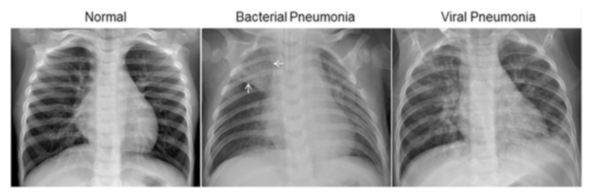
- 정상적인 흉부 X-RAY(왼쪽): 이미지에서 비정상적인 음영 영역이 없는 깨끗한 폐를 보여줌
- 세균성 폐렴 (가운데): 일반적으로 오른쪽 상부엽(흰색 화살표)에 나타남
- 바이러스성 폐렴 (오른쪽): 양쪽 폐에서 보다 확산된 "interstitial(조직 사이에 있는)" 패턴

👉 이 패턴을 잘 읽어내는 딥러닝 알고리즘을 만들어보자!

---
## CNN Model
### Set-up

In [1]:
# import pakages
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
# necessary variables
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

BATCH_SIZE = 32  #16 -> 32로 수정 
EPOCHS = 15      #10 -> 15로 수정

print(ROOT_PATH)

/aiffel/aiffel


### Load data
- 데이터 디렉토리 구조
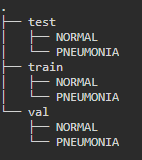

#### data split

In [3]:
# 디렉토리별 데이터 개수 확인
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

train_count = len(train_filenames)
test_count = len(test_filenames)
val_count = len(val_filenames)

print("train:", train_count)
print("test:", test_count)
print("validation:", val_count)

train: 5216
test: 624
validation: 16


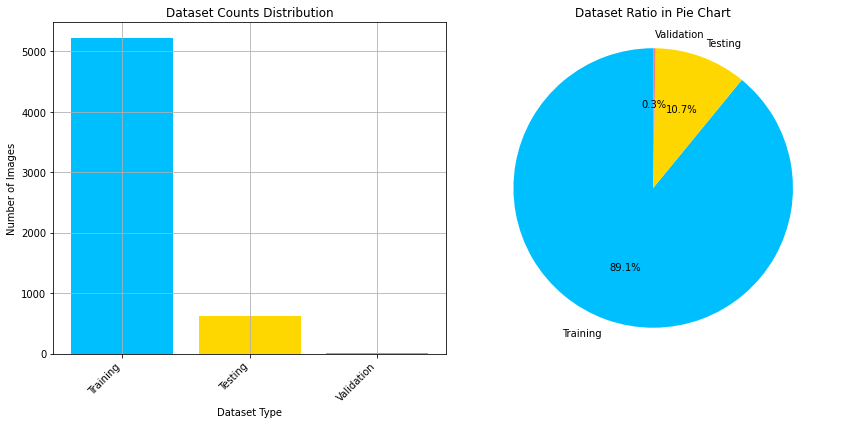

In [4]:
# visualize dataset
import matplotlib.pyplot as plt

# Prepare Data for Visualization
labels = ["Training", "Testing", "Validation"]
counts = [train_count, test_count, val_count]
colors = ["deepskyblue", "gold", "lightcoral"]  # Choose distinct colors for clarity

# Create the charts
plt.figure(figsize=(12, 6))  

# Bar Chart
plt.subplot(121)
plt.bar(labels, counts, color=colors)
plt.xlabel("Dataset Type")
plt.ylabel("Number of Images")
plt.title("Dataset Counts Distribution")
plt.grid(True)  # Add gridlines for visual reference
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better visibility

# Create the pie chart
plt.subplot(122)  # Position the pie chart in the second subplot
plt.pie(counts, labels=labels, colors=colors, autopct="%1.1f%%", startangle=90)
plt.title("Dataset Ratio in Pie Chart")
plt.axis("equal")  # Ensure a circular pie chart

# Adjust layout for better visualization
plt.tight_layout()  # Prevent overlapping elements

# Display the combined chart
plt.show()

- train: 89%
- test : 10.7%
- validation :0.3%
    - validation이 너무 없어서 train 데이터 일부를 가져옴
        - train과 val에 있는 데이터를 모은 다음에 
        - train : val를 80:20으로 분할

In [5]:
# train 데이터와 validation 데이터를 모두 filenames에 담기
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

train_count = len(train_filenames)
val_count = len(val_filenames)

print("train:", train_count)
print("validation:", val_count)

train: 4185
validation: 1047


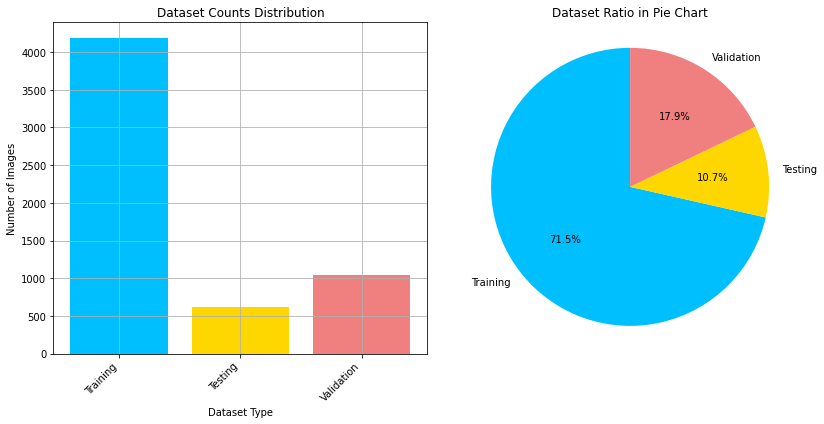

In [6]:
# 다시 데이터수 그래프로 확인
# Prepare Data for Visualization
labels = ["Training", "Testing", "Validation"]
counts = [train_count, test_count, val_count]
colors = ["deepskyblue", "gold", "lightcoral"]

# Create the charts
plt.figure(figsize=(12, 6))  

# Bar Chart
plt.subplot(121)
plt.bar(labels, counts, color=colors)
plt.xlabel("Dataset Type")
plt.ylabel("Number of Images")
plt.title("Dataset Counts Distribution")
plt.grid(True)  # Add gridlines for visual reference
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better visibility

# Create the pie chart
plt.subplot(122)  # Position the pie chart in the second subplot
plt.pie(counts, labels=labels, colors=colors, autopct="%1.1f%%", startangle=90)
plt.title("Dataset Ratio in Pie Chart")
plt.axis("equal")  # Ensure a circular pie chart

# Adjust layout for better visualization
plt.tight_layout()  # Prevent overlapping elements

# Display the combined chart
plt.show()

- 적절한 비율로 수정되었다

#### train 데이터 안에 정상 이미지 수와 폐렴 이미지 수 확인

In [7]:
# 파일 경로에서 정상이미지, 폐렴 이미지 구분 힌트얻기
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


- train 디렉토리에 `NORMAL`, `PNEUMONIA` 폴더로 이미지가 구분되어있다
    - 파일 이름에 `NORMAL`이 있는 이미지는 -> 정상이미지
    - 파일 이름에 `PNEUMONIA`이 있는 이미지는 -> 폐렴이미지

In [8]:
# 정상이미지
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# 폐렴이미지
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


- 정상보다 폐렴 이미지수가 3배 정도 더 많다
- 데이터 클래스별 balance가 좋아야 좋은 학습결과가 나온다
    - ✅ 데이터 클래스 balance 조정필요
- test, validation 데이터셋은 평가용이기때문에 학습과 관련이 없다 = imbalance 데이터셋이어도 문제 X

### mini-batch
- tf.data instance 생성
  - tf.data는 tensorflow에서 학습시킬때 mini-batch로 작업하도록 도움<br>
[참고] [mini-batch 사용 이유](https://acdongpgm.tistory.com/202)    

In [9]:
# tf.data instance 생성
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [10]:
# Train 데이터셋, validation 데이터셋 개수 확인
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


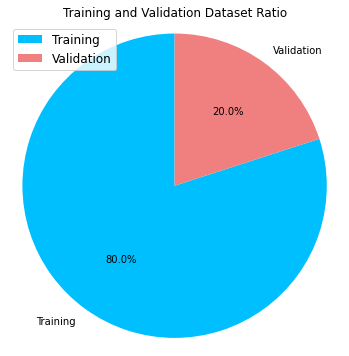

In [11]:
# 배치데이터 시각화
# Prepare data for the pie chart
labels = ["Training", "Validation"]
sizes = [TRAIN_IMG_COUNT, VAL_IMG_COUNT]
colors = ["deepskyblue", "lightcoral"]

# Create the pie chart
plt.figure(figsize=(6, 6))  # Adjust figure size as needed
plt.pie(sizes, labels=labels, colors=colors, autopct="%1.1f%%", startangle=90)
plt.title("Training and Validation Dataset Ratio")

# Customize pie chart appearance (optional)
plt.axis("equal")  # Equal aspect ratio ensures a circular pie chart
plt.legend(fontsize=12)  # Adjust legend font size if needed

# Display the pie chart
plt.show()

In [12]:
# 레이블 데이터 생성 함수
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

### Data Preprocessing 1
- 이미지 리사이즈
- 이미지 픽셀 정규화 
- 데이터 타입 float 변경

In [13]:
# 이미지 형식 변경 함수
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정 : 180x180
    return img

# 이미지 파일 경로로 이미지와 레이블 읽어오는 함수
def process_path(file_path):
    label = get_label(file_path) # 레이블 뽑기
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [14]:
# train, validation dataset 만들기
# num_parallel_calls 파라미터에 위에서 할당한 AUTOTUNE 변수 이용
## AUTOTUNE : 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [15]:
# 이미지 리사이즈 결과, 레이블 확인
for image, label in train_ds.take(1): # 하나의 데이터만 가져온다
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [16]:
# test dataset 만들기
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print("test dataset:", TEST_IMAGE_COUNT)

test dataset: 624


In [17]:
# 데이터 형식 확인
train_ds

<ParallelMapDataset shapes: ((180, 180, 3), ()), types: (tf.float32, tf.bool)>

### Data Preprocessing 3 - Data augmentation
- 총 2개의 함수를 활용해서 data augmentation진행

**[flip : 좌우반전]**
- tf.image.random_flip_left_right() 사용

**[zoom : 10%]**
- tf.image.random_zoom() 사용

**[rotation : 10°]**
- 지금 이미지 데이터 형식이 tensorflow tensor라 `tf.image.rot90`를 사용해보려고했는데 이건 90도 단위로만 회전되는것 같다 
- `PIL` 방식을 사용하기로 결정
- 문제는 PIL 방식은 `NumPy array`를 사용하기때문에 데이터 형식 변환이 필요하다
> 넘파이배열로 변환해서 이미지 회전 진행후에 다시 tensoflow tensor로 변환 진행

In [35]:
# from PIL import Image
# import numpy as np

# # Enable eager execution if needed
# tf.config.run_functions_eagerly(True)

# # data augmentation - rotate, normalization
# def rotate_image_tensor(image_tensor, degrees):
#     # Convert tf.float32 image to [0, 255] range and tf.uint8
#     image_np = tf.make_ndarray(tf.cast(image_tensor * 255, tf.uint8))
    
#     # Convert NumPy array to PIL image
#     pil_image = Image.fromarray(image_np)

#     # Rotate the image
#     rotated_pil_image = pil_image.rotate(degrees)

#     # Convert rotated image back to NumPy array
#     rotated_image_np = np.array(rotated_pil_image)

#     # Convert NumPy array back to TensorFlow tensor and scale to [0, 1] range
#     rotated_image_tensor = tf.convert_to_tensor(rotated_image_np, dtype=tf.float32) / 255.0

#     return rotated_image_tensor

In [36]:
print(tf.executing_eagerly())

True


In [25]:
# # data augmentation - flip & zoom
# def augment(image,label):
#     # Randomly flip left or right
#     image = tf.image.random_flip_left_right(image)
#     # Randomly zoom in or out by cropping and resizing
#     scale = tf.random.uniform(shape=[], minval=0.9, maxval=1.1) # zoom in or out by 10%
#     height, width = tf.shape(image)[0], tf.shape(image)[1]
#     new_height = tf.cast(scale * tf.cast(height, tf.float32), tf.int32)
#     new_width = tf.cast(scale * tf.cast(width, tf.float32), tf.int32)

#     image = tf.image.central_crop(image, central_fraction=scale)
#     image = tf.image.resize(image, [height, width])

#     return image,label

### tf.data pipeline setting

In [37]:
# # tf.data 파이프라인설정 - 데이터 변환
# '''
# shuffle() : 고정 크기 버퍼를 유지, 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택
# repeat() : epoch를 진행하면서 여러 번 데이터셋을 불러옴
#     - 예: 100개의 데이터를 10번 반복하면 1000개의 데이터가 필요
#     - repeat()를 사용하면 자동으로 데이터를 맞춰줌
# batch() : BATCH_SIZE에서 정한 만큼 배치로 만들어줌
#     - 예: 100개의 데이터를 10개의 배치로 나누면 각 배치에는 10개의 데이터로 나뉨
# prefetch() : 학습 데이터를 나눠서 읽어옴
#     - 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비
#     - 리소스의 유휴 상태를 줄일 수 있음
# '''
# def prepare_for_training(ds, shuffle_buffer_size=1000):
#     ## data augment 함수 2개 적용
#     # data augmentation 1 - flip & zoom
#     ds = ds.map(augment, num_parallel_calls=AUTOTUNE)
    
#     # data augmentation 2 - rotate, normalization
#     degrees = 10
#     ds = ds.map(lambda x, y: (rotate_image_tensor(x, degrees), y),
#                 num_parallel_calls=AUTOTUNE)
    
#     ds = ds.shuffle(buffer_size=shuffle_buffer_size)
#     ds = ds.repeat()
#     ds = ds.batch(BATCH_SIZE)  # 32
#     ds = ds.prefetch(buffer_size=AUTOTUNE)
    
#     return ds

# train_ds = prepare_for_training(train_ds)
# val_ds = prepare_for_training(val_ds)

AttributeError: in user code:

    /tmp/ipykernel_346/1706209239.py:20 None  *
        lambda x, y: (rotate_image_tensor(x, degrees), y)
    /tmp/ipykernel_346/3213733354.py:10 rotate_image_tensor  *
        image_np = tf.make_ndarray(tf.cast(image_tensor * 255, tf.uint8))
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/framework/tensor_util.py:597 MakeNdarray  **
        shape = [d.size for d in tensor.tensor_shape.dim]
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/framework/ops.py:401 __getattr__
        self.__getattribute__(name)

    AttributeError: 'Tensor' object has no attribute 'tensor_shape'


- rotation 부분이 잘 해결이 안된다.. rotation은 버리고 나머지 기능만 정리해서 augmentation을 진행한다

In [43]:
# # augment함수에 pixel normalization 부분을 추가
# # data augmentation - flip & zoom & normalization
# def augment(image, label):
#     # Randomly flip left or right
#     image = tf.image.random_flip_left_right(image)
    
#     # Randomly zoom in or out by cropping and resizing
#     scale = tf.random.uniform(shape=[], minval=0.9, maxval=1.1) # zoom in or out by 10%
#     height, width = tf.shape(image)[0], tf.shape(image)[1]
    
#     # Avoid negative values in central crop
#     crop_size = tf.cast(tf.cast(tf.maximum(height, width), tf.float32) * (1.0 - scale), tf.int32)
#     image = tf.image.central_crop(image, central_fraction=1.0 - scale)
    
#     # Resize back to the original size
#     image = tf.image.resize(image, [height, width])
    
#     # Normalize the image to the [0, 1] range
#     image = image / 255.0
    
#     return image, label

In [44]:
# def prepare_for_training(ds, shuffle_buffer_size=1000):
#     # data augmentation including normalization
#     ds = ds.map(augment, num_parallel_calls=AUTOTUNE)
    
#     ds = ds.shuffle(buffer_size=shuffle_buffer_size)
#     ds = ds.repeat()
#     ds = ds.batch(BATCH_SIZE)  # 32
#     ds = ds.prefetch(buffer_size=AUTOTUNE)
    
#     return ds

# train_ds = prepare_for_training(train_ds)
# val_ds = prepare_for_training(val_ds)

### 데이터 시각화
- 첫번째 배치를 추출해서 image, label 데이터 셋으로 구분후 이미지 확인

In [18]:
# 이미지 배치를 입력해서 여러장의 이미지 확인
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

~- augment 부분에서 `central_crop`작업이 음의 값을 만들어서 생기는 에러가 생겨서 다시 함수 수정~

In [48]:
# def augment(image, label):
#     # Randomly flip left or right
#     image = tf.image.random_flip_left_right(image)

#     # Randomly zoom in or out by cropping and resizing
#     scale = tf.random.uniform(shape=[], minval=0.1, maxval=0.2)  # Adjust the range as needed
#     height, width = tf.shape(image)[0], tf.shape(image)[1]

#     # Calculate crop size to avoid negative values
#     crop_height = tf.cast(tf.cast(height, tf.float32) * (1.0 - scale), tf.int32)
#     crop_width = tf.cast(tf.cast(width, tf.float32) * (1.0 - scale), tf.int32)

#     # Ensure crop size is not zero
#     crop_height = tf.maximum(crop_height, 1)
#     crop_width = tf.maximum(crop_width, 1)

#     # Perform central crop
#     image = tf.image.central_crop(image, central_fraction=1.0 - scale)
#     image = tf.image.resize(image, [crop_height, crop_width])

#     # Resize back to the original size
#     image = tf.image.resize(image, [height, width])
    
#     # Explicitly set the shape
#     image.set_shape([None, None, 3])

#     # Normalize the image to the [0, 1] range
#     image = image / 255.0

#     return image, label

In [49]:
# def prepare_for_training(ds, shuffle_buffer_size=1000):
#     # data augmentation including normalization
#     ds = ds.map(augment, num_parallel_calls=AUTOTUNE)
    
#     ds = ds.shuffle(buffer_size=shuffle_buffer_size)
#     ds = ds.repeat()
#     ds = ds.batch(BATCH_SIZE)  # 32
#     ds = ds.prefetch(buffer_size=AUTOTUNE)
    
#     return ds

# train_ds = prepare_for_training(train_ds)
# val_ds = prepare_for_training(val_ds)

# # 배치별로 이미지 확인
# image_batch, label_batch = next(iter(train_ds))
# show_batch(image_batch.numpy(), label_batch.numpy())

ValueError: in user code:

    /tmp/ipykernel_346/3934280400.py:3 augment  *
        image = tf.image.random_flip_left_right(image)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper  **
        return target(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/image_ops_impl.py:422 random_flip_left_right
        return _random_flip(image, 1, random_func, 'random_flip_left_right')
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/image_ops_impl.py:537 _random_flip
        raise ValueError(

    ValueError: 'image' (shape (None, None, None, None, 3)) must have either 3 or 4 dimensions.


- 쉽지않다. 텐서플로우 텐서 형식의 파일을 다뤄본적이 없어서 더 왜 이런 오류가 생기는지 이해하는게 어렵다. 
- 단순하게 텐서플로우 내장 기능만 사용해서 augmentation을 진행한다

In [19]:
# Final augmentation function
def augment(image, label):
    # Randomly flip left or right
    image = tf.image.random_flip_left_right(image)
    # adjust contrast
    imgate = tf.image.random_contrast(image, 0.2, 0.5)
    
    return image,label

In [20]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    # data augmentation including normalization
    ds = ds.map(augment, num_parallel_calls=AUTOTUNE)
    
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)  # 32
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

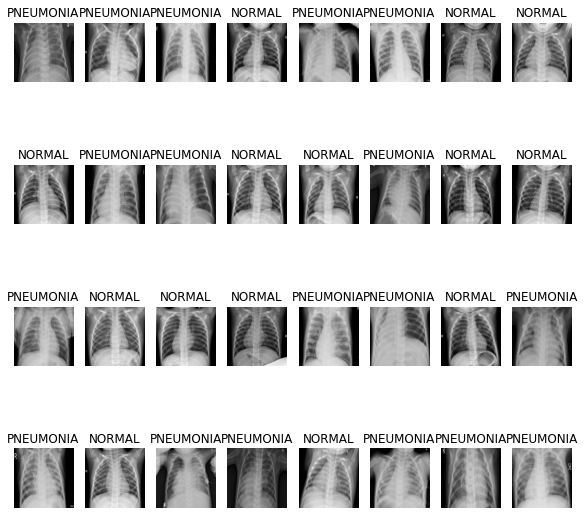

In [21]:
# 배치별로 이미지 확인
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

### CNN modeling
- CNN 구조에서 `feature extraction`, `classification`부분을 **block**으로 나눠서 모델을 만든다

#### Convolution block

---
**SeperableConv2D layer**
- SeparableConv2D는 Depthwise Convolution과 Pointwise Convolution을 결합한 구조
    - Depthwise Convolution : 각 입력 채널에 대해 별도의 필터를 적용 
    - Pointwise Convolution : 각 출력 채널에 대해 하나의 필터를 적용 <br>
    
👉 *Conv2D는 일반적인 컨볼루션 필터를 사용하지만, SeperableConv2D는 위 두 convonlution을 분리해서 사용*

**SeparableConv2D vs Conv2D** 
- 모델 크기 : SeparableConv2D < Conv2D
- 학습 속도 : SeparableConv2D > Conv2D
- 성능 : SeparableConv2D $\approx$ Conv2D

👉 일반적으로 SeparableConv2D는 Conv2D보다 모델의 크기와 학습 속도를 줄이면서 유사한 성능을 얻을 수 있는 방법으로 사용된다고 한다 ~(근데 직접 해본 사람들은 또 큰 효과가 없다고도 하는데 일단 따라가본다)~<br>
[출처] Bard, [블로그](https://ejleep1.tistory.com/1204)

In [22]:
# convolution block
'''
- convolution 2번 
    - activation : relu
    - same padding
    - kernel size : 3x3
- batch normalization
- max pooling 
    - pool size : 2x2
'''
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

#### Dense block

In [23]:
# dense block
'''
activation : relu
batch normalization
dropout
'''
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

---
**[참고자료] Batch Normalization 과 Dropout을 같이 사용하는거 성능과 어떤 관련이 있을까?**
- 별로다 논문 :[Understanding the Disharmony between Dropout and Batch Normalization by Variance Shift](https://openaccess.thecvf.com/content_CVPR_2019/papers/Li_Understanding_the_Disharmony_Between_Dropout_and_Batch_Normalization_by_Variance_CVPR_2019_paper.pdf)
- 괜찮다 논문 : [Rethinking the Usage of Batch Normalization and Dropout in the Training of Deep Neural Networks](https://arxiv.org/pdf/1905.05928.pdf)

🤓 퀘스트 끝나고 찬찬히 읽어보자

---

In [24]:
# build model = convolution block + dense block 합치기
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### Data Preprocessing 3 - data imbalance

`Weight balancing`
- training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여
- Keras는 model.fit()을 호출할 때 파라미터로 넘기는 class_weight 에 이러한 클래스별 가중치를 세팅할 수 있도록 지원

- `weight_for_0` : 'Normal' 이미지에 사용할 weight
- `weight_for_1` : 'Pneumonia' 이미지에 사용할 weight
    - 위 weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정

**[참고자료][딥러닝에서 클래스 불균형을 다루는 방법](https://3months.tistory.com/414)**

In [25]:
# weight balancing
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


### Model training - CNN
- gpu를 사용해서 모델 훈련

In [26]:
# gpu로 모델 빌드, 컴파일
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [27]:
# gpu로 모델학습
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/15
130/130 [==============================] - 106s 416ms/step - loss: 0.4630 - accuracy: 0.7445 - precision: 0.9371 - recall: 0.7035 - val_loss: 0.5899 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 2/15
130/130 [==============================] - 53s 410ms/step - loss: 0.2368 - accuracy: 0.9050 - precision: 0.9717 - recall: 0.8986 - val_loss: 0.6878 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 3/15
130/130 [==============================] - 54s 417ms/step - loss: 0.1817 - accuracy: 0.9305 - precision: 0.9765 - recall: 0.9288 - val_loss: 1.0632 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 4/15
130/130 [==============================] - 55s 423ms/step - loss: 0.1507 - accuracy: 0.9438 - precision: 0.9828 - recall: 0.9410 - val_loss: 1.5608 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 5/15
130/130 [==============================] - 57s 442ms/step - loss: 0.1574 - accur

### Visualize history

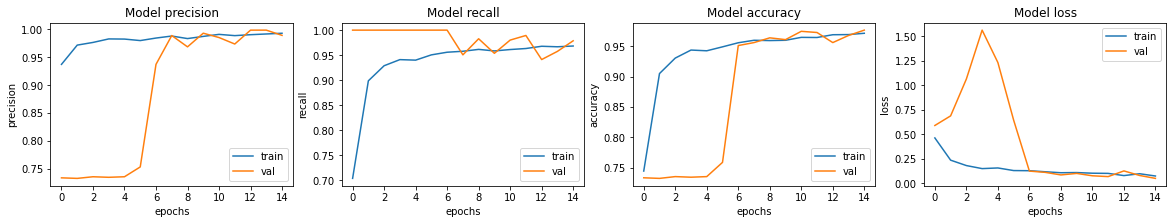

In [28]:
# visualize history
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### Evaluate model

In [29]:
# evaluate model
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 5s 226ms/step - loss: 0.9004 - accuracy: 0.7644 - precision: 0.7306 - recall: 0.9872
Loss: 0.9004389643669128,
Accuracy: 0.7644230723381042,
Precision: 0.7305502891540527,
Recall: 0.9871794581413269


- 모델 정확도는 76% 밖에 안되지만, 재현율은 98%로 매우 높다. 
- ResNet-18 모델의 성능도 확인해봐야겠다

---

## 메모리 관리
- 메모리 관리를 위해 cnn 모델은 삭제후 resnet모델을 구현, 학습할 예정
- model.save() : 모델 정보 및 학습 가중치를 모두 저장
    - 추후에 불러오려면 `tf.keras.models.load_model()`
- history 저장 : pickle.dump
    - 추후에 불러오려면 `history = pickle.load(open('/trainHistoryDict', "rb"))`

In [30]:
# 모델 저장
model.save('cnn_model')

INFO:tensorflow:Assets written to: cnn_model/assets


In [36]:
# history 저장
import os
import pickle

# Specify the directory path
directory_path = '/aiffel/Quest/Main_quest_04'

# Ensure the directory exists, create it if not
os.makedirs(directory_path, exist_ok=True)

# Full file path
file_path = os.path.join(directory_path, 'train_history_dict.pkl')

# Assuming history.history is defined somewhere in your code
with open(file_path, 'wb') as file_pi:
    pickle.dump(history, file_pi)

In [35]:
# history 불러오기 테스트
history = pickle.load(open('/trainHistoryDict', "rb"))
print(history)

{'loss': [0.46299639344215393, 0.23675183951854706, 0.18166102468967438, 0.1507159024477005, 0.15738432109355927, 0.13084672391414642, 0.1292669177055359, 0.11860654503107071, 0.10867124795913696, 0.11054381728172302, 0.10380344837903976, 0.10204742103815079, 0.07969076186418533, 0.09844447672367096, 0.07536326348781586], 'accuracy': [0.7444711327552795, 0.9050480723381042, 0.9305288195610046, 0.9437500238418579, 0.9425480961799622, 0.9490384459495544, 0.9557692408561707, 0.9598557949066162, 0.9593750238418579, 0.9598557949066162, 0.9646634459495544, 0.9644230604171753, 0.9689903855323792, 0.9692307710647583, 0.9713942408561707], 'precision': [0.93712317943573, 0.971727728843689, 0.9765226244926453, 0.9828340411186218, 0.982556164264679, 0.9798725247383118, 0.9843905568122864, 0.9880199432373047, 0.9834546446800232, 0.9873712062835693, 0.9909970164299011, 0.9887454509735107, 0.9904227256774902, 0.991710901260376, 0.9930209517478943], 'recall': [0.703524112701416, 0.8986442685127258, 0.

In [37]:
# 모델 삭제
del model

In [38]:
# history 삭제
del history

---
---
## ResNet-18
**ResNet** 
- 2015년 ILSVRC 대회 (ImageNet Large Scale Visual Recognition Challenge)에서 엄청난 성능을 보여주었던 모델
- 특징
    - Residual Connection으로 학습된 정보가 데이터 처리과정에서 손실되는 것을 방지했다
    - ResNet의 Residual Connection은 이후에 나오는 Transformer와 같은 모델에도 사용되고 있다
    
**ResNet-18**
- ResNet의 가장 작은 버전

**[작업순서]**
1. Residual block 구성
    - ResNet에서의 weight layer 구성
        1. 3x3 CNN
        2. BatchNormalization
        3. 활성화 함수 ReLU
        <img src = "residual_connection.max-800x600.png" width = "30%" height = "30%">
2. 아래 그림대로 ResNet 구현<br>
(참고사항 : 해당 table은 ImageNet Challenge를 가정했기 때문에 filter개수는 튜닝하면서 바꿔야함!)
<img src = "resnet-18.max-800x600.png" width = "30%" height = "30%">

### Residual block 
<img src = "residual_connection.max-800x600.png" width = "30%" height = "30%">

1. 3x3 CNN<br>
    - [논문](https://arxiv.org/pdf/1512.03385.pdf)을 보면 skip connection으로 차원을 맞추는 작업을 할때 stride를 2로 지정한다고 한다.
    - 이 부분을 반영하도록 구조를 만든다
2. BatchNormalization<br>
3. 활성화 함수 ReLU<br>

[참고][kaggle notebook](https://www.kaggle.com/code/songrise/implementing-resnet-18-using-keras)
- 위 노트북을 참고해서 class 디자인

* 참고2
- activation function을 `tf.nn.relu`이렇게 호출하기도 한다! [링크](https://www.tensorflow.org/api_docs/python/tf/nn/relu)

In [40]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SeparableConv2D, MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from tensorflow.keras.callbacks import EarlyStopping

In [66]:
'''
n_filter : 각 layer에서 전달
stride : 
    - 기본적으로 1을 사용하고, 
    - `down_sample`이라는 변수를 설정해서 2를 사용하도록 만듬
kernel_size : 3
weight initializer : He initializer

'''
class ResidualBlock(Model):
    def __init__(self, n_filter: int, down_sample=False):
        super().__init__()
        
        # 여기 안에서만 사용하는 변수라서 변수명 앞에 '__'붙임
        self.__n_filter = n_filter
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]
        
        KERNEL_SIZE = (3,3)
        
        # use He initialization
        INITIALIZER = "he_normal"
        
        self.conv_1 = SeparableConv2D(self.__n_filter, strides=self.__strides[0],
                           kernel_size=KERNEL_SIZE, padding='same', kernel_initializer=INITIALIZER)
        self.bn_1 = BatchNormalization()
        self.conv_2 = SeparableConv2D(self.__n_filter, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INITIALIZER)
        self.bn_2 = BatchNormalization()
        self.merge = Add()
        
        if self.__down_sample:
            # perform down sampling using stride of 2
            self.res_conv = SeparableConv2D(
                self.__n_filter, strides=2, kernel_size=(1, 1), 
                kernel_initializer=INITIALIZER, padding="same")
            self.res_bn = BatchNormalization()
        
    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        
        return out

### ResNet
<img src = "resnet-18.max-800x600.png" width = "30%" height = "30%">

In [67]:
# ResNet18 구현
'''
num_classes : 분류해야하는 클래스 수
'''
class ResNet18(Model):
    def __init__(self, num_classes, **kwargs):
        super().__init__(**kwargs)
            
        # conv1레이어는 직접 만들고
        self.conv_1 = SeparableConv2D(64, (7, 7), strides=2,
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResidualBlock(64)
        self.res_1_2 = ResidualBlock(64)
        self.res_2_1 = ResidualBlock(128, down_sample=True) # 논문을 보면 여기에서 stride를 1, 1x1 convolution layer를 사용한다
        self.res_2_2 = ResidualBlock(128)
        self.res_3_1 = ResidualBlock(256, down_sample=True)
        self.res_3_2 = ResidualBlock(256)
        self.res_4_1 = ResidualBlock(512, down_sample=True)
        self.res_4_2 = ResidualBlock(512)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, 
                          self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        
        return out

In [44]:
# 이미지 사이즈 조정
IMAGE_SIZE = [32, 32]

In [45]:
# train, validation dataset 만들기
# num_parallel_calls 파라미터에 위에서 할당한 AUTOTUNE 변수 이용
## AUTOTUNE : 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [46]:
# 이미지 리사이즈 결과, 레이블 확인
for image, label in train_ds.take(1): # 하나의 데이터만 가져온다
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (32, 32, 3)
Label:  False


In [47]:
# test dataset 만들기
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

In [48]:
# 파이프라인 다시 생성
# tf.data 파이프라인설정 - 데이터 변환
'''
shuffle() : 고정 크기 버퍼를 유지, 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택
repeat() : epoch를 진행하면서 여러 번 데이터셋을 불러옴
    - 예: 100개의 데이터를 10번 반복하면 1000개의 데이터가 필요
    - repeat()를 사용하면 자동으로 데이터를 맞춰줌
batch() : BATCH_SIZE에서 정한 만큼 배치로 만들어줌
    - 예: 100개의 데이터를 10개의 배치로 나누면 각 배치에는 10개의 데이터로 나뉨
prefetch() : 학습 데이터를 나눠서 읽어옴
    - 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비
    - 리소스의 유휴 상태를 줄일 수 있음
'''
def prepare_for_training(ds, shuffle_buffer_size=1000):
    # data augmentation including normalization
    ds = ds.map(augment, num_parallel_calls=AUTOTUNE)
    
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)  # 32
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [49]:
# weight balancing 그대로 설정
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


In [68]:
# 모델 생성
with tf.device('/GPU:0'):
    model = ResNet18(1)
    model.build(input_shape = (None,32,32,3))
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [69]:
model.summary()

Model: "res_net18_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_71 (Separab multiple                  403       
_________________________________________________________________
batch_normalization_70 (Batc multiple                  256       
_________________________________________________________________
max_pooling2d_11 (MaxPooling multiple                  0         
_________________________________________________________________
residual_block_16 (ResidualB multiple                  9984      
_________________________________________________________________
residual_block_17 (ResidualB multiple                  9984      
_________________________________________________________________
residual_block_18 (ResidualB multiple                  36480     
_________________________________________________________________
residual_block_19 (ResidualB multiple                  

In [ ]:
# gpu로 모델학습
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/15
130/130 [==============================] - 59s 374ms/step - loss: 0.2533 - accuracy: 0.7437 - precision: 0.7437 - recall: 1.0000 - val_loss: 0.6066 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 2/15
 91/130 [====================>.........] - ETA: 9s - loss: 0.1748 - accuracy: 0.7507 - precision: 0.7507 - recall: 1.0000 

In [ ]:
# visualize history
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
# evaluate model
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')